In [ ]:
# %%
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import keras.utils as image
from keras.applications import MobileNetV3Small
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

/tmp/ipykernel_3226857/1293519201.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-25 23:51:50.700870: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 23:51:50.744397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 23:

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [ ]:
# %%
# Define directories
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'
# %%
image_size = (224, 224, 3)

In [4]:
# %%
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# %%
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [6]:
# Load MobileNetV3 (small) with pre-trained weights on ImageNet
base_mobilenetv3_small = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_mobilenetv3_small.output
x = GlobalAveragePooling2D()(x)

# Create the model
mobilenetv3_small_with_gap = Model(inputs=base_mobilenetv3_small.input, outputs=x)


2024-03-25 23:52:15.045531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 914 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-03-25 23:52:15.049111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7381 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
2024-03-25 23:52:15.053195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 37953 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
2024-03-25 23:52:15.056459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37953 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bus i

In [7]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [8]:
# Extract features using MobileNetV3 (small)
batch_size = 8
train_features = extract_features(mobilenetv3_small_with_gap, train_images, batch_size)
test_features = extract_features(mobilenetv3_small_with_gap, test_images, batch_size)


2024-03-25 23:52:17.527209: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-25 23:52:17.639598: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1/1 [==============================] - 0s 58ms/step


2024-03-25 23:52:18.355053: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-25 23:52:18.399146: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


1/1 [==============================] - 0s 385ms/step


In [9]:
# %%
# Define the parameter grid for Naive Bayes
nb_param_grid = {}  # No hyperparameters for Gaussian Naive Bayes

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Use GridSearchCV to find the best parameters for Naive Bayes
nb_grid_search = GridSearchCV(nb_classifier, nb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
nb_grid_search.fit(train_features, train_labels)

# Get the best parameters for Naive Bayes
best_nb_params = nb_grid_search.best_params_

# Use the best parameters to train the final Naive Bayes model
final_nb_classifier = GaussianNB(**best_nb_params)
start_time_nb = time.time()
final_nb_classifier.fit(train_features, train_labels)
train_time_nb = time.time() - start_time_nb

# Predict labels for the test set using Naive Bayes
nb_predictions = final_nb_classifier.predict(test_features)

# Evaluate accuracy for Naive Bayes
nb_accuracy = accuracy_score(test_labels, nb_predictions)
print("\nBest Naive Bayes Parameters:", best_nb_params)
print("Naive Bayes Accuracy:", nb_accuracy)


Best Naive Bayes Parameters: {}
Naive Bayes Accuracy: 0.9696969696969697


In [10]:
# Additional evaluation metrics for Naive Bayes
precision_nb = precision_score(test_labels, nb_predictions, average='weighted')
recall_nb = recall_score(test_labels, nb_predictions, average='weighted')
f1_nb = f1_score(test_labels, nb_predictions, average='weighted')

print("Train Time (sec) Naive Bayes:", train_time_nb)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time_nb = nb_grid_search.cv_results_['mean_fit_time'][nb_grid_search.best_index_]
print("Train Time (sec) Grid Naive Bayes:", grid_train_time_nb)

# Calculate Matthews Correlation Coefficient (MCC) for Naive Bayes
mcc_nb = matthews_corrcoef(test_labels, nb_predictions)
print("Matthews Correlation Coefficient (MCC) Naive Bayes:", mcc_nb)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = nb_grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)


Train Time (sec) Naive Bayes: 0.045313358306884766
Train Time (sec) Grid Naive Bayes: 0.04219190279642741
Matthews Correlation Coefficient (MCC) Naive Bayes: 0.965093506084831
Optimization Algorithm Accuracy: 0.9650084434770111


In [11]:

# Confusion matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(test_labels, nb_predictions)
precision_nb = precision_score(test_labels, nb_predictions, average='weighted')

FP_nb = conf_matrix_nb.sum(axis=0) - np.diag(conf_matrix_nb)  
FN_nb = conf_matrix_nb.sum(axis=1) - np.diag(conf_matrix_nb)
TP_nb = np.diag(conf_matrix_nb)
TN_nb = conf_matrix_nb.sum()

In [12]:

# %%
# Display results for Naive Bayes
print("\nResults for Naive Bayes:")
print("Precision (Naive Bayes):", precision_nb)
print("Recall (Naive Bayes):", recall_nb)
print("F1 Score (Naive Bayes):", f1_nb)
print("True Positive Rate (TPR) (Naive Bayes):", np.mean(TP_nb / (TP_nb + FN_nb)))
print("True Negative Rate (TNR) (Naive Bayes):", np.mean(TN_nb / (TN_nb + FP_nb)))
print("False Positive Rate (FPR) (Naive Bayes):", np.mean(FP_nb / (FP_nb + TN_nb)))
print("False Negative Rate (FNR) (Naive Bayes):", np.mean(FN_nb / (TP_nb + FN_nb)))

print("False Discovery Rate (FDR) (Decision Tree):", np.mean(FP_nb / (FP_nb + TP_nb)))
print("False Omission Rate (FOR) (Decision Tree):", np.mean(FN_nb / (FN_nb + TN_nb)))
print("Matthews Correlation Coefficient (MCC) (Naive Bayes):", mcc_nb)



Results for Naive Bayes:
Precision (Naive Bayes): 0.9750020732779355
Recall (Naive Bayes): 0.9696969696969697
F1 Score (Naive Bayes): 0.9695989576534498
True Positive Rate (TPR) (Naive Bayes): 0.9546675640205052
True Negative Rate (TNR) (Naive Bayes): 0.9987955490920797
False Positive Rate (FPR) (Naive Bayes): 0.0012044509079203035
False Negative Rate (FNR) (Naive Bayes): 0.04533243597949481
False Discovery Rate (FDR) (Decision Tree): 0.058539682539682544
False Omission Rate (FOR) (Decision Tree): 0.0012009417783092331
Matthews Correlation Coefficient (MCC) (Naive Bayes): 0.965093506084831


In [13]:
conf_matrix_nb

array([[  5,   0,   0,   0,   0,   2,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   6,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  19,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  12,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  16,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  19,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  16,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      

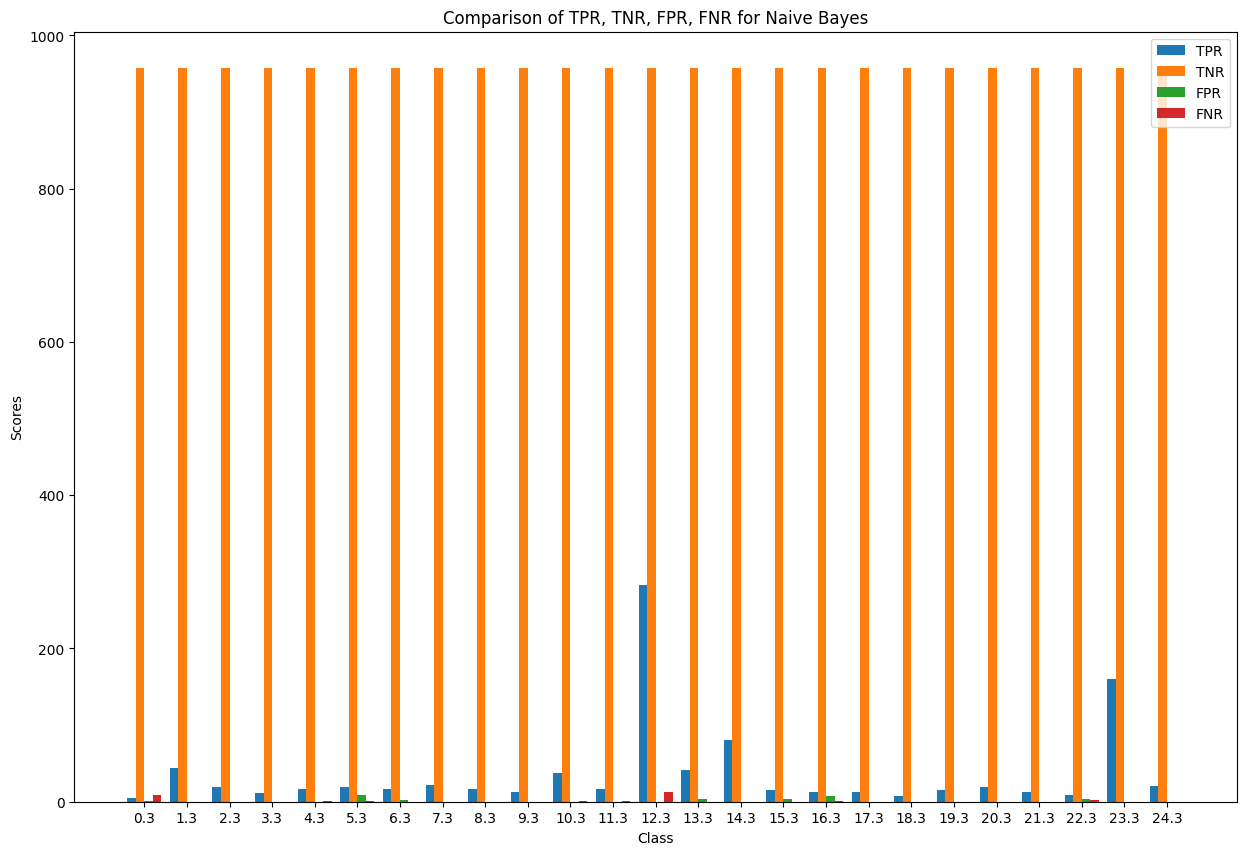

In [14]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP_nb, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_nb, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_nb, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_nb, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for Naive Bayes')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

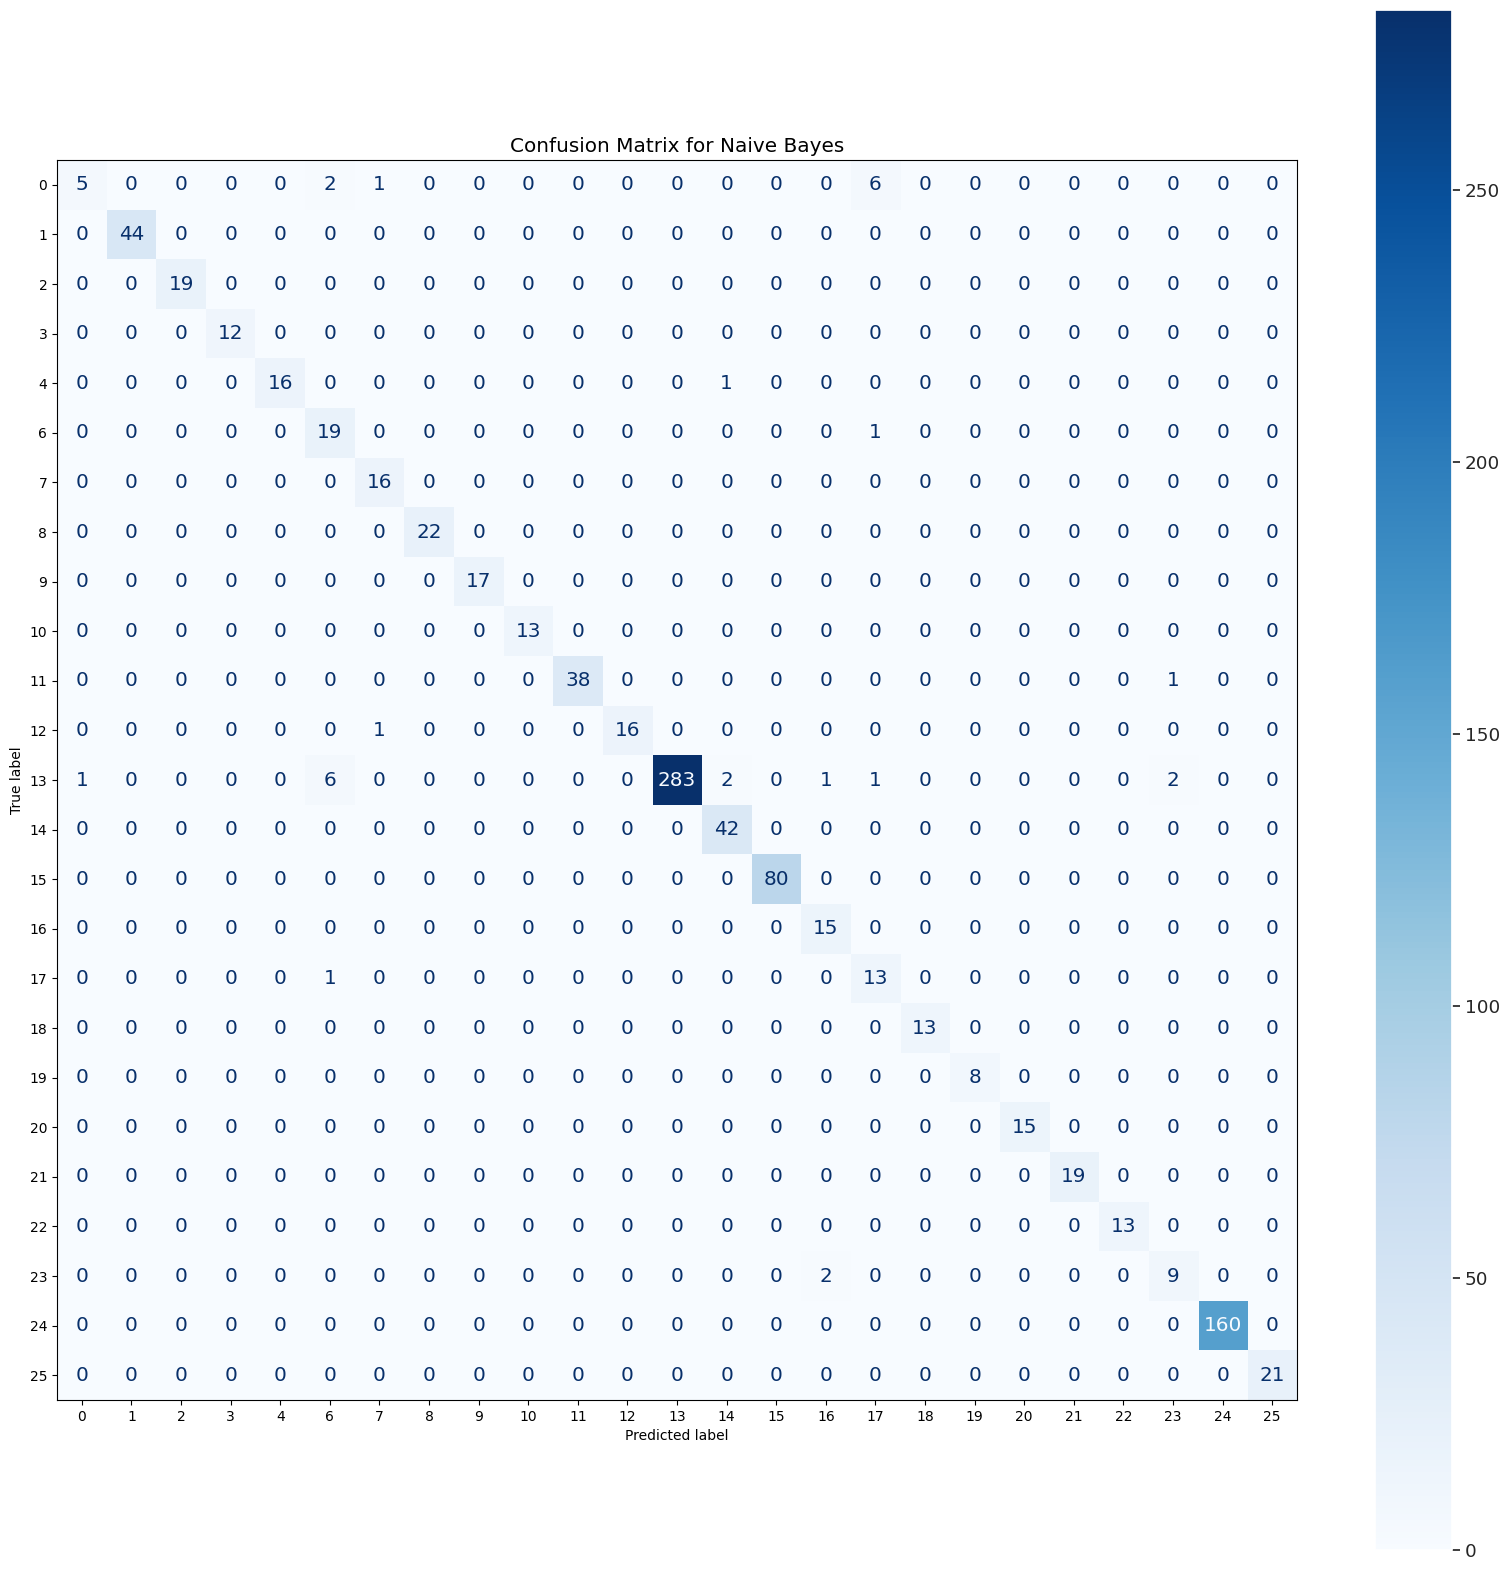

: 

In [15]:
# Plot Confusion Matrix for Naive Bayes
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_nb, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()